## 03 - Modelling

## Optional - Colab Setup

In [0]:
def upgrade_runtime_ram():
    meminfo = subprocess.getoutput('cat /proc/meminfo').split('\n')

    memory_info = {entry.split(':')[0]: int(entry.split(':')[1].replace(' kB','').strip()) for entry in meminfo}

    if memory_info['MemTotal'] > 17000000:
        return

    a = []
    while(1):
        a.append('1')

In [0]:
def restart_runtime():
    os.kill(os.getpid(), 9)

In [0]:
def setup_rapids():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    device_name = pynvml.nvmlDeviceGetName(handle)
    if (device_name != b'Tesla T4') and (device_name != b'Tesla P4') and (device_name != b'Tesla P100-PCIE-16GB'):
        print("Wrong GPU - Restarting Runtime")
        restart_runtime()


    # clone RAPIDS AI rapidsai-csp-utils scripts repo
    !git clone https://github.com/rapidsai/rapidsai-csp-utils.git

    # install RAPIDS
    !bash rapidsai-csp-utils/colab/rapids-colab.sh 0.13


    # set necessary environment variables 
    dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
    sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
    sys.path

    # update pyarrow & modules 
    exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

In [0]:
def setup_conda():
    if not 'Miniconda3-4.5.4-Linux-x86_64.sh' in os.listdir():
        !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh && bash Miniconda3-4.5.4-Linux-x86_64.sh -bfp /usr/local

    if not ('EPFL-Capstone-Project' in os.listdir()) and (os.getcwd().split('/')[-1] != 'EPFL-Capstone-Project'):
        !git clone https://github.com/helmigsimon/EPFL-Capstone-Project  
    if 'EPFL-Capstone-Project' in os.listdir():
        os.chdir('EPFL-Capstone-Project')

    !conda env create -f environment.yml
    !conda activate exts-ml

In [0]:
def setup_drive():
    #Mounting Google Drive
    global drive
    from google.colab import drive
    drive.mount('/content/drive')

In [0]:
try:
    import sys,os,subprocess
    
    upgrade_runtime_ram()
    setup_drive()

    #Setting up PyPi Packages
    !pip install geopandas sparse-dot-topn pdpipe category-encoders catboost
    import geopandas as gpd
    import sparse_dot_topn.sparse_dot_topn as ct
    import pdpipe as pdp
    import category_encoders

    #Setting up Conda Packages
    setup_conda()
    
    #Initializing NLTK
    import nltk
    nltk.download('stopwords')
    nltk.download('punkt')
    
    #Setting up RAPIDS AI
    import pynvml
    setup_rapids()
    
    from cuml import UMAP
    
except ModuleNotFoundError as e:
    print(e)
    print('Not in colab environment, continuing to run locally')
    from umap import UMAP

## Imports

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split,  StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
tqdm.pandas()

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.model_selection import KFold
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [0]:
from lib.transformers import *
from lib.pipelines import *
from lib.processing import save_to_pkl, load_from_pkl
from lib.visualization import GridSearchPlotter
from data.util.paths import DATA_PATH

In [0]:
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [0]:
try:
    from cuml import LinearRegression, RandomForestRegressor, Ridge
except ModuleNotFoundError:
    pass

In [0]:
from catboost import CatBoostRegressor

## Loading Data

In [0]:
metadata_df, image_embeddings_df = tuple(load_from_pkl(i,DATA_PATH) for i in ('metadata','image_embeddings'))
df = metadata_df.merge(image_embeddings_df,how='inner',on='release_id')
df = OutlierRemover(features=['number_of_tracks'] + [i for i in df.columns if 'umap' in i]).fit_transform(df[(df['running_time'] < 180) | (df['running_time'].isna())])

In [0]:
del metadata_df, image_embeddings_df

In [0]:
col_set = {
    'format': {
        'description': 'format_description_', 
        'name': 'format_name_', 
        'text': ('format_text_clean'),
        'quantity': ('format_quantity')
    },
    'geography': {
        'superregion': 'superregion_',
        'region': 'region_',
        'country': 'country_'
    },
    'timeperiod': {
        'period': 'period_',
        'era': 'era_'
    },
    'genre': 'genre_',
    'style': 'style_',
    'null': None,
    'indicator': lambda x: x.max() == 1 and x.min() == 0,
    'image_embedding': 'image_umap_'
}
column_store = ColumnStore()
column_store.fit(df,col_set)

## Preparing for Machine Learning

In [0]:
X_tr, X_te, y_tr, y_te = train_test_split(df.drop('market_value',axis=1),df.market_value)

In [0]:
df_sample = pd.concat([X_tr,y_tr],axis=1).sample(frac=0.1)
X_tr_sample = df_sample.drop('market_value',axis=1)
y_tr_sample = df_sample['market_value']

In [0]:
del df

## Setting up Dummy Regression for baseline

In [0]:
dummy_regressor = DummyRegressor(strategy='mean')

In [20]:
dummy_regressor.fit(X_tr,np.log(y_tr).values)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [0]:
dummy_pred = dummy_regressor.predict(X_te)

In [22]:
r2_score(y_te,np.exp(dummy_pred))

-0.07991737808981703

In [23]:
mean_absolute_error(y_te,np.exp(dummy_pred))

10.57154569276055

## Linear Regression - Record Store

In [0]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [0]:
record_store_lr_transformer = ColumnTransformer(transformers=[
    ('year_encoder', OneHotEncoder(dtype=np.uint8,handle_unknown='ignore'), ['year'])
], remainder='passthrough')

In [0]:
record_store_lr_removal_columns = set([
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','country','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','days_since_last_sale','title', 'release_id'
])

In [0]:
record_store_lr_processing = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','master_id','format_name'])),
    ('record_store_column_remover', ColumnRemover(record_store_lr_removal_columns)),
    ('preprocessing',record_store_lr_transformer),
    ('scaler', RobustScaler()),                             
])

record_store_lr_pipe = Pipeline([
    ('processing', record_store_lr_processing),
    ('lr', GridSearchCV(
        LinearRegression(),
        param_grid={
            'normalize':[False,True]
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
    ))
])

In [28]:
record_store_lr_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   17.5s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.8s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('leave_one_out_encoding',
                                  LeaveOneOutEncoder(cols=['artist', 'label',
                                                           'format_text',
                                                           'master_id',
                                                           'format_name'],
                                                     drop_invariant=False,
                                                     handle_missing='value',
                                                     handle_unknown='va...
                              estimator=LinearRegression(algorithm='eig', fit_intercept=Tr

In [29]:
record_store_lr_pipe['lr'].best_score_

-0.5720429551900099

In [30]:
record_store_lr_pred = record_store_lr_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [31]:
r2_score(y_te,np.exp(record_store_lr_pred))

0.0972992763524495

In [32]:
mean_absolute_error(y_te,np.exp(record_store_lr_pred))

8.620359544627519

## Linear Regression - Full Information

In [0]:
full_information_lr_transformer = ColumnTransformer(transformers=[
    ('units_for_sale_imputer', SimpleImputer(strategy='constant',fill_value=0),['units_for_sale']),
    ('average_rating_imputer', SimpleImputer(strategy='mean'),['average_rating']),
    ('year_encoder', OneHotEncoder(dtype=np.uint8,handle_unknown='ignore'), ['year'])
], remainder='passthrough')

In [0]:
full_information_columns = set([
    'units_for_sale','community_have','community_want','average_rating','rating_count'
])
full_information_lr_removal_columns = record_store_lr_removal_columns - full_information_columns

In [0]:
full_information_lr_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','master_id','format_name'])),
    ('record_store_column_remover', ColumnRemover(full_information_lr_removal_columns)),
    ('preprocessing',full_information_lr_transformer),
    ('scaler', RobustScaler()),
    ('lr', GridSearchCV(
        LinearRegression(),
        param_grid={
            'normalize':[False,True]
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
    ))
])

In [36]:
full_information_lr_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    6.0s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.8s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('running_time_imputer',
                 RunningTimeImputer(number_of_tracks='number_of_tracks',
                                    running_time='running_time')),
                ('leave_one_out_encoding',
                 LeaveOneOutEncoder(cols=['artist', 'label', 'format_text',
                                          'master_id', 'format_name'],
                                    drop_invariant=False,
                                    handle_missing='value',
                                    handle_unknown='value', random_state=None,
                                    return_df=True, sigm...
                              estimator=LinearRegression(algorithm='eig', fit_intercept=True, normalize=False, handle=<cuml.common.handle.Handle object at 0x7f4f5ccb23b0>, verbose=False, output_type='input'),
                              iid='deprecated', n_jobs=-1,
                              param_grid={'normalize': [False, True]},
           

In [37]:
full_information_lr_pipe['lr'].best_score_

-0.5114643737095746

In [38]:
full_information_lr_pred = record_store_lr_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [39]:
r2_score(y_te,np.exp(full_information_lr_pred))

0.0972992763524495

In [40]:
mean_absolute_error(y_te,np.exp(full_information_lr_pred))

8.620359544627519

## Lasso Regression - Record Store

## Lasso Regression - Full Information

## Ridge Regression - Record Store

In [0]:
record_store_ridge_removal_columns, record_store_ridge_transformer, full_information_ridge_removal_columns, full_information_ridge_transformer = (
    record_store_lr_removal_columns,
    record_store_lr_transformer,
    full_information_lr_removal_columns,
    full_information_lr_transformer
)

In [0]:
record_store_ridge_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id'])),
    ('record_store_column_remover', ColumnRemover(record_store_ridge_removal_columns)),
    ('preprocessing',record_store_ridge_transformer),
    ('scaler', RobustScaler()),
    ('ridge', GridSearchCV(
        Ridge(normalize=False,solver='eig'),
        param_grid={
            'alpha': np.linspace(1e-3,1e3,10),
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
        return_train_score=True
    ))
])

In [43]:
record_store_ridge_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.3s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   37.4s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('running_time_imputer',
                 RunningTimeImputer(number_of_tracks='number_of_tracks',
                                    running_time='running_time')),
                ('leave_one_out_encoding',
                 LeaveOneOutEncoder(cols=['artist', 'label', 'format_text',
                                          'format_name', 'master_id'],
                                    drop_invariant=False,
                                    handle_missing='value',
                                    handle_unknown='value', random_state=None,
                                    return_df=True, sigm...
                              estimator=Ridge(alpha=1.0, solver='eig', fit_intercept=True, normalize=False, handle=<cuml.common.handle.Handle object at 0x7f4f4a9f3a50>, output_type='input'),
                              iid='deprecated', n_jobs=-1,
                              param_grid={'alpha': array([1.00000e-03, 1.11112e+02, 2.22223e+02, 3.3

In [0]:
plotter = GridSearchPlotter(record_store_ridge_pipe['ridge'])

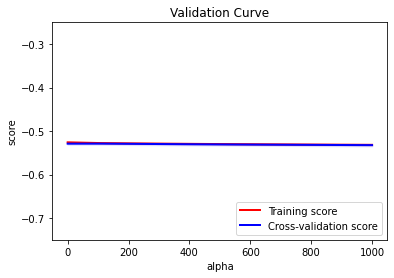

In [45]:
plotter.plot_validation_curve(parameter='alpha',ylim=(-0.75,-0.25))

In [46]:
record_store_ridge_pipe['ridge'].best_score_

-0.5288410589336794

In [47]:
record_store_ridge_pipe['ridge'].best_params_

{'alpha': 111.11200000000001}

In [48]:
record_store_ridge_pred = record_store_ridge_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [49]:
r2_score(y_te,np.exp(record_store_ridge_pred))

0.15918522237804833

In [50]:
mean_absolute_error(y_te,np.exp(record_store_ridge_pred))

8.59614836121766

## Ridge - Full Information

In [0]:
full_information_ridge_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id'])),
    ('record_store_column_remover', ColumnRemover(full_information_ridge_removal_columns)),
    ('preprocessing',full_information_ridge_transformer),
    ('scaler', StandardScaler()),
    ('ridge', GridSearchCV(
        Ridge(normalize=False,solver='eig'),
        param_grid={
            'alpha': np.logspace(-3,3,10),
        },
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=5,
        n_jobs=-1,
        return_train_score=True
    ))
])

In [71]:
full_information_ridge_pipe.fit(X_tr,np.log(y_tr).values)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   41.6s finished
/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


Pipeline(memory=None,
         steps=[('running_time_imputer',
                 RunningTimeImputer(number_of_tracks='number_of_tracks',
                                    running_time='running_time')),
                ('leave_one_out_encoding',
                 LeaveOneOutEncoder(cols=['artist', 'label', 'format_text',
                                          'format_name', 'master_id'],
                                    drop_invariant=False,
                                    handle_missing='value',
                                    handle_unknown='value', random_state=None,
                                    return_df=True, sigm...
                              estimator=Ridge(alpha=1.0, solver='eig', fit_intercept=True, normalize=False, handle=<cuml.common.handle.Handle object at 0x7f4f5ccc11f0>, output_type='input'),
                              iid='deprecated', n_jobs=-1,
                              param_grid={'alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469

In [0]:
plotter = GridSearchPlotter(full_information_ridge_pipe['ridge'])

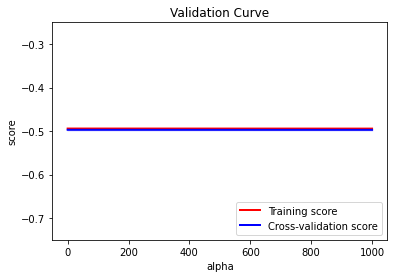

In [73]:
plotter.plot_validation_curve(parameter='alpha',ylim=(-0.75,-0.25))

In [74]:
full_information_ridge_pipe['ridge'].best_score_

-0.4970954883637084

In [75]:
full_information_ridge_pipe['ridge'].best_params_

{'alpha': 10.0}

In [76]:
full_information_ridge_pred = full_information_ridge_pipe.predict(X_te)

/usr/local/lib/python3.6/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected column ('F') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


In [77]:
r2_score(y_te,np.exp(full_information_ridge_pred))

-5.68611893017056

In [78]:
mean_absolute_error(y_te,np.exp(full_information_ridge_pred))

8.770060484090658

## Random Forest - Record Store

In [0]:
record_store_random_forest_removal_columns = [
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','country','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','days_since_last_sale','title','release_id'
]
record_store_random_forest_removal_columns.extend(
    column_store._indicator
)
record_store_random_forest_removal_columns = set(record_store_random_forest_removal_columns)

In [0]:
record_store_random_forest_preprocessing_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id','year'])),
    ('reduce_indicators', IndicatorReducer(indicators=column_store._indicator,algorithm=PCA,components=40)),
    ('record_store_column_remover', ColumnRemover(record_store_random_forest_removal_columns)),
    ('cast_to_32', FunctionTransformer(func=lambda x: x.values.astype(np.float32)))
])

random_forest = RandomForestRegressor()

record_store_random_forest_search_pipe = Pipeline([
    ('preprocessing',record_store_random_forest_preprocessing_pipe),
    ('grid_search', GridSearchCV(
        random_forest,
        cv=KFold(n_splits=5,shuffle=True),
        param_grid={
            'n_estimators': np.linspace(10,200,5).astype(int)
        },
        verbose=50,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        return_train_score=True
    ))
])

record_store_random_forest_pipe = Pipeline([
    ('preprocessing',record_store_random_forest_preprocessing_pipe),
    ('random_forest',random_forest)
])

In [0]:
record_store_random_forest_search_pipe.fit(X_tr_sample,np.log(y_tr_sample).values.astype(np.float32))

In [0]:
record_store_random_forest_plotter = GridSearchPlotter(record_store_random_forest_search_pipe.steps[-1][1])
record_store_random_forest_plotter.plot_validation_curve(parameter='n_estimators',ylim=(-1,0))

In [0]:
record_store_random_forest_search_pipe.steps[-1][1].best_score_

In [0]:
record_store_random_forest_search_pipe.steps[-1][1].best_params_

In [0]:
record_store_random_forest_pipe.fit(X_tr,np.log(y_tr).values.astype(np.float32))

In [0]:
record_store_random_forest_te_pred = record_store_random_forest_pipe.predict(X_te)

In [0]:
pd.Series(record_store_random_forest_te_pred).describe()

In [0]:
r2_score(y_te,np.exp(record_store_random_forest_te_pred))

In [0]:
mean_absolute_error(y_te,np.exp(record_store_random_forest_te_pred))

## Random Forest - Full Information

In [0]:
full_information_random_forest_removal_columns = record_store_random_forest_removal_columns - full_information_columns

In [0]:
full_information_random_forest_transformer = ColumnTransformer(transformers=[
    ('units_for_sale_imputer', SimpleImputer(strategy='constant',fill_value=0),['units_for_sale']),
    ('average_rating_imputer', SimpleImputer(strategy='mean'),['average_rating']),
], remainder='passthrough')

In [0]:
full_information_random_forest_preprocessing_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('leave_one_out_encoding', LeaveOneOutEncoder(cols=['artist','label','format_text','format_name','master_id','year'])),
    ('reduce_indicators', IndicatorReducer(indicators=column_store._indicator,algorithm=PCA,components=40)),
    ('record_store_column_remover', ColumnRemover(full_information_random_forest_removal_columns)),
    ('cast_to_32', FunctionTransformer(func=lambda x: x.values.astype(np.float32)))
])

random_forest = RandomForestRegressor()

full_information_random_forest_search_pipe = Pipeline([
    ('preprocessing',full_information_random_forest_preprocessing_pipe),
    ('grid_search', GridSearchCV(
        random_forest,
        cv=KFold(n_splits=5,shuffle=True),
        param_grid={
            'n_estimators': np.linspace(10,200,5).astype(int)
        },
        verbose=50,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        return_train_score=True
    ))
])

full_information_random_forest_pipe = Pipeline([
    ('preprocessing',random_forest_preprocessing_pipe),
    ('random_forest',random_forest)
])

In [0]:
full_information_random_forest_search_pipe.fit(X_tr_sample,np.log(y_tr_sample))

In [0]:
full_information_random_forest_plotter = GridSearchPlotter(random_forest_search_pipe.steps[-1][1])
full_information_random_forest_plotter.plot_validation_curve(parameter='n_estimators',ylim=(-1,0))

In [0]:
full_information_random_forest_search_pipe.steps[-1][1].best_score_

In [0]:
full_information_random_forest_search_pipe.steps[-1][1].best_params_

In [0]:
full_information_random_forest_pipe.fit(X_tr,np.log(y_tr).values.astype(np.float32))

In [0]:
full_information_random_forest_te_pred = random_forest_pipe.predict(X_te)

In [0]:
full_information_r2_score(y_te,np.exp(random_forest_te_pred))

In [0]:
full_information_mean_absolute_error(y_te,np.exp(random_forest_te_pred))

## Catboost - Record Store

In [0]:
record_store_catboost_removal_columns = set([
    'market_price','units_for_sale','have','want','average_rating','rating_count','last_sold','lowest','median',
    'highest','track_titles','genre','style','community_have','community_want','formats','thumb_url',
    'release_url','format_description','days_since_last_sale','title','release_id'
])

In [0]:
record_store_catboost_processing_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('record_store_column_remover', ColumnRemover(record_store_catboost_removal_columns)),
])

catboost = CatBoostRegressor(
    random_seed=0,
    cat_features=['year','format_text','master_id','format_name','artist','label','country'],
    boosting_type='Ordered',
    n_estimators=100,
    learning_rate=0.16681005,
    l2_leaf_reg=3,
    border_count=170,
    max_depth=10,
)

record_store_catboost_grid_pipe = Pipeline([
    ('processing', record_store_catboost_processing_pipe),
    ('grid_search', GridSearchCV(
        catboost,
        param_grid={
            'learning_rate': np.linspace(1e-3,1e1,5),
            'l2_leaf_reg': [1,3,5,8],
            'border_count': np.linspace(0,200,5)
        },
        n_jobs=1,
        cv=KFold(n_splits=5,shuffle=True),
        verbose=5,
        scoring='neg_mean_absolute_error',
        return_train_score=True)
    )
])

record_store_catboost_pipe = Pipeline([
    ('processing', record_store_catboost_processing_pipe),
    ('catboost',catboost)
])

In [0]:
record_store_catboost_grid_pipe.fit(X_tr_sample,np.log(y_tr_sample))

In [0]:
record_store_catboost_plot = GridSearchPlotter(catboost_grid_pipe.steps[-1][1])
record_store_catboost_plot.plot_validation_curve(parameter='max_depth',ylim=(-1,0))

In [0]:
record_store_catboost_grid_pipe.steps[-1][1].best_score_

In [0]:
record_store_catboost_grid_pipe.steps[-1][1].best_params_

In [173]:
record_store_catboost_pipe.fit(X_tr,np.log(y_tr))

0:	learn: 0.8746400	total: 18.1ms	remaining: 1.79s
1:	learn: 0.8626872	total: 35.8ms	remaining: 1.75s
2:	learn: 0.8519616	total: 53.3ms	remaining: 1.72s
3:	learn: 0.8425970	total: 70.6ms	remaining: 1.69s
4:	learn: 0.8341569	total: 88.4ms	remaining: 1.68s
5:	learn: 0.8265830	total: 106ms	remaining: 1.66s
6:	learn: 0.8193116	total: 123ms	remaining: 1.63s
7:	learn: 0.8137007	total: 140ms	remaining: 1.61s
8:	learn: 0.8086176	total: 157ms	remaining: 1.59s
9:	learn: 0.7995927	total: 178ms	remaining: 1.6s
10:	learn: 0.7952944	total: 197ms	remaining: 1.59s
11:	learn: 0.7878523	total: 219ms	remaining: 1.6s
12:	learn: 0.7850427	total: 238ms	remaining: 1.59s
13:	learn: 0.7823424	total: 255ms	remaining: 1.57s
14:	learn: 0.7797238	total: 274ms	remaining: 1.55s
15:	learn: 0.7732372	total: 299ms	remaining: 1.57s
16:	learn: 0.7684556	total: 319ms	remaining: 1.56s
17:	learn: 0.7668142	total: 336ms	remaining: 1.53s
18:	learn: 0.7633686	total: 356ms	remaining: 1.52s
19:	learn: 0.7602951	total: 376ms	rema

Pipeline(memory=None,
         steps=[('processing',
                 Pipeline(memory=None,
                          steps=[('running_time_imputer',
                                  RunningTimeImputer(number_of_tracks='number_of_tracks',
                                                     running_time='running_time')),
                                 ('record_store_column_remover',
                                  ColumnRemover(cols_to_remove={'average_rating',
                                                                'community_have',
                                                                'community_want',
                                                                'days_since_last_sale',
                                                                'format_description',
                                                                'formats',
                                                                'genre', 'have',
                                   

In [0]:
record_store_catboost_te_pred = record_store_catboost_pipe.predict(X_te)

In [176]:
r2_score(y_te,np.exp(record_store_catboost_te_pred))

0.1783573241375015

In [177]:
mean_absolute_error(y_te,np.exp(record_store_catboost_te_pred))

8.403480464666007

## CatBoost - Full Information

In [0]:
full_information_catboost_removal_columns = record_store_catboost_removal_columns - full_information_columns

In [0]:
full_information_catboost_processing_pipe = Pipeline([
    ('running_time_imputer',RunningTimeImputer('running_time','number_of_tracks')),
    ('record_store_column_remover', ColumnRemover(record_store_catboost_removal_columns))
])

full_information_catboost_grid_pipe = Pipeline([
    ('processing', catboost_processing_pipe),
    ('grid_search', GridSearchCV(
        catboost,
        param_grid={'max_depth': np.linspace(10,32,5).astype(int)},
        n_jobs=-1,
        cv=KFold(n_splits=5,shuffle=True),
        scoring='neg_mean_absolute_error',
        verbose=50,
        return_train_score=True)
    )
])

In [0]:
full_information_catboost_grid_pipe.fit(X_tr_sample,np.log(y_tr_sample))

In [0]:
full_information_catboost_plot = GridSearchPlotter(catboost_grid_pipe.steps[-1][1])
full_information_catboost_plot.plot_validation_curve(parameter='max_depth',ylim=(-1,0))

In [0]:
full_information_catboost_grid_pipe.steps[-1][1].best_score_

In [0]:
full_information_catboost_grid_pipe.steps[-1][1].best_params_

In [0]:
full_information_catboost_pipe.fit(X_tr,np.log(y_tr))

In [0]:
catboost_te_pred = catboost_pipe.predict(X_te)

In [0]:
r2_score(y_te,np.exp(full_information_catboost_te_pred))

In [0]:
mean_absolute_error(y_te,np.exp(full_information_catboost_te_pred))